# CellViT Inference Code

This notebook is separated into 2 primary stages:

1. Exploratory data analysis - Visualization of H&E images and their masks, showing different cell types etc.
2. Binary nuclei segmentation using CellVitSam model.

Semantic segmentation is not possible using only the pretrained CellVit models. Their models have different classification taxonomies, which can be found at: https://tio-ikim.github.io/CellViT-Inference/examples.html#classification-taxonomies

Their different cell types, cause the nuclei_type_map decoder to classify cells into different categories than our broad_cell_type

For that issue we have 2 possible solutions which are explored later:

- Mapping our broad_cell_type (10 classes) to one of the classification taxonomies. However benchmarking this classification agains a decoder fine-tuned on VirTues for 10 classes would be unfair as prediction tasks on aggregated cell types might be found easier for the model.
- Training the CellVit decoder again for predicting our broad_cell_type, while keeping the encoder frozen, this seems like the most fair option as we could train the decoder for both CellVit and Virtues encoder, using the same epochs, optimizer, and parameters to benchmark the representation quality.

In [1]:
import sys
import os
import warnings
warnings.filterwarnings("ignore", message=".*weights_only=False.*") # ignore warning from torch for loading models
# 1. Get the path to the directory above the current one (i.e., the project root)
# os.getcwd() gives '.../project_root/notebook'
# '..' steps up to '.../project_root'
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
from config import *
print(project_root)

import torch
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pickle as pkl
from omegaconf import OmegaConf
from einops import rearrange
from PIL import Image
from tqdm import tqdm

/home/mizia/project-2-gradient_tri_scent


In [2]:
# project imports
import importlib
from src.dataset.datasets.mm_base import build_mm_datasets
from src.models.wrappers.cellvit_wrapper import CellViTWrapper

In [3]:
import src.models.cellvit_decoder as cd
importlib.reload(cd)
from src.models.cellvit_decoder import CellViTDecoder
from src.utils.metrics import CombinedLoss, calculate_dice_score, calculate_f1_score, calculate_panoptic_quality, calculate_iou_score
from src.models.utils.train_loop import train_loop
from src.dataset.datasets.embeddings_dataset import EmbeddingsDataset, ImageDataset

num_classes = 10
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
device = "cuda"

In [4]:
base_cfg = OmegaConf.load(os.path.join(project_root, "src/dataset/configs/base_config.yaml"))
base_cfg.marker_embedding_dir = os.path.join(project_root, "src/dataset/esm2_t30_150M_UR50D")
orion_subset_cfg = OmegaConf.load(os.path.join(project_root, "src/dataset/configs/orion_subset.yaml"))
ds_cfg = OmegaConf.merge(base_cfg, orion_subset_cfg)

In [5]:
ds = build_mm_datasets(ds_cfg)

2025-12-16 19:19:04.563 | DEBUG    | src.dataset.datasets.mm_base:__init__:44 - Loading dataset orion from /data/virtues_orion_dataset/virtues_example/orion_subset
2025-12-16 19:19:04.571 | INFO     | src.dataset.datasets.multiplex_base:__init__:30 - Multiplex Normalization metadata: QuantileMultiplexNormalizeMetadata(normalizer_name='q_99', rnd_crop_folder_name='random_crops_256_no_log', channel_file_name='channels', mean_name='mean', std_name='std', quantile_path='quantiles/q99.csv')
2025-12-16 19:19:04.865 | INFO     | src.dataset.datasets.multiplex_base:__init__:40 - Crop folder /data/virtues_orion_dataset/virtues_example/orion_subset/cycif/random_crops_256_no_log exists
/home/mizia/project-2-gradient_tri_scent/src/dataset/datasets/multiplex_base.py:59: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future

In [6]:
CELL_TYPE_LABELS = [
    None, "Stroma", "Endothelia", "Macrophage", "Tumor",
    "Helper T cell", "Cytotoxic T cell", "Other", "Treg", "B cells"
] # labels from the label encoder

def visualize_images(ds, num_cols=1):
    """Visualize two rows of tissue images:
    - First row: raw tissue images
    - Second row: tissue images overlaid with cell type masks
    Args:
        ds: multimodal dataset
        num_cols: number of tissue images to visualize
    """
    he_ds = ds.unimodal_datasets['he']
    tissue_ids = ds.get_tissue_ids()
    cmap = plt.get_cmap('tab10')

    plt.figure(figsize=(num_cols * 5, 2 * 5))
    plt.suptitle("Tissue Images")
    for i in range(num_cols):
        img = rearrange(he_ds._get_tissue_all_channels(tissue_ids[i]), 'c h w -> h w c')
        img = (img - img.min()) / (img.max() - img.min())
        mask = ds[0].get_cell_mask(tissue_ids[i], task="broad_cell_type", resize=True)
        
        plt.subplot(2, num_cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Tissue {i+1}")

        # Second row: image + mask
        plt.subplot(2, num_cols, num_cols + i + 1)
        plt.imshow(img)
        plt.imshow(np.ma.masked_where(mask == 0, mask), cmap=cmap, alpha=0.9, vmin=0, vmax=9)
        plt.axis('off')
        plt.title(f"Tissue {i+1} + Mask")

        if i == 0:
            unique_vals = np.unique(mask)
            legend_elements = []
            for val in unique_vals:
                if val == 0 or CELL_TYPE_LABELS[val] is None:
                    continue
                legend_elements.append(
                    Patch(facecolor=cmap(val), edgecolor='k', label=CELL_TYPE_LABELS[val])
                )
            if legend_elements:
                plt.legend(handles=legend_elements)

**Visualize dataset properties such as image/mask shapes, cell types and value counts for each cell**

In [7]:
he_ds = ds[0].unimodal_datasets['he']
tissue_ids = ds[0].get_tissue_ids()

img = he_ds._get_tissue_all_channels(tissue_ids[0])
mask = ds[0].get_cell_mask(tissue_ids[0], task="broad_cell_type", resize=True) # mask is gotten from multimodal dataset, not unimodal

print("Tissue ids: ", tissue_ids)
print(f'\nTissue shape: {img.shape} / Mask shape: {mask.shape}')

label_encoder_path = os.path.join(ds[0].cell_masks_dir, "labelencoder_broad_cell_type.npy") # 10 classes / or labelencoder_cell_type.npy
label_encoder: list = np.load(label_encoder_path, allow_pickle=True)

print("\nLabel encoder mapping:", label_encoder)

values, counts = np.unique(mask, return_counts=True)
values = [label_encoder[v] for v in values]
print(f"\nValue counts: {dict(zip(values, counts))}")

Tissue ids:  ['orion_zupwxfxb_0' 'orion_cxlhytpd_0' 'orion_cnrgtuax_0'
 'orion_zgkkfgaw_0' 'orion_zcmsymch_0' 'orion_vkpuqrne_0'
 'orion_dmayaltl_0' 'orion_cxnlpalc_0' 'orion_eljqkbji_0'
 'orion_vsutyrqb_0' 'orion_tkcdjcyi_0' 'orion_pzyzeozt_0'
 'orion_mabvrlfp_0' 'orion_finlgcrv_0' 'orion_sqnznrln_0'
 'orion_fndswptg_0' 'orion_oodvkkan_0' 'orion_shbesytu_0'
 'orion_ztqdiium_0' 'orion_ptidrepk_0' 'orion_vmvftcqv_0'
 'orion_uwoiponh_0' 'orion_skqutwlh_0' 'orion_qswyvkjn_0'
 'orion_aijcgfvk_0' 'orion_hmmxjico_0' 'orion_dforbase_0'
 'orion_yuqhctso_0' 'orion_mrsesczl_0' 'orion_prihtkje_0'
 'orion_ktcaojrj_0' 'orion_bzoahikx_0' 'orion_svksaiov_0'
 'orion_eieanjbk_0' 'orion_cqxbwsky_0']

Tissue shape: (3, 3000, 3000) / Mask shape: (3000, 3000)

Label encoder mapping: ['None' 'Stroma' 'Endothelia' 'Macrophage' 'Tumor' 'Helper T cell'
 'Cytotoxic T cell' 'Other' 'Treg' 'B cells']

Value counts: {'None': 6903461, 'Stroma': 757687, 'Endothelia': 58239, 'Macrophage': 166726, 'Tumor': 926298, 'He

In [8]:
# visualize_images(ds, 3)

In [9]:
# utility functions for getting image and mask
# these rely on the global ds and he_ds variables
def get_mask(tissue_id, task="broad_cell_type", resize=True):
    return ds[0].get_cell_mask(tissue_id, task=task, resize=resize)

def get_image(tissue_id):
    return torch.from_numpy(he_ds._get_tissue_all_channels(tissue_id)).float() # unnormalized for cellvit

## CellVit Structure

The cellvit pypi documentation provides very little information about the usage of python package. Instead it only shows how to use the CLI. Here we get to know the structure of the CellVit package and the list of its modules

In [10]:
import cellvit
cellvit_dir = os.path.dirname(cellvit.__file__)
print(cellvit_dir)
sys.path.insert(0, cellvit_dir)

modules = []
for root, dirs, files in os.walk(cellvit_dir):
    for file in files:
        if file.endswith(".py") and file != "__init__.py":
            rel_path = os.path.relpath(os.path.join(root, file), cellvit_dir)
            module_name = rel_path.replace(os.path.sep, ".").replace(".py", "")
            modules.append(module_name)

print("Modules in cellvit package:")
print(modules)

/opt/conda/envs/tissuevit/lib/python3.12/site-packages/cellvit
Modules in cellvit package:
['check_system', 'detect_cells', 'ray_logger_test', 'config.config', 'config.templates', 'data.dataclass.cell_graph', 'data.dataclass.wsi', 'data.dataclass.wsi_meta', 'inference.cli', 'inference.inference', 'inference.overlap_cell_cleaner', 'inference.postprocessing_cupy', 'inference.postprocessing_numpy', 'models.base.vision_transformer', 'models.cell_segmentation.backbones', 'models.cell_segmentation.cellvit', 'models.cell_segmentation.cellvit_256', 'models.cell_segmentation.cellvit_sam', 'models.cell_segmentation.postprocessing', 'models.classifier.linear_classifier', 'models.utils.blocks', 'models.utils.download_models', 'models.utils.sam_utils', 'utils.cache_models', 'utils.cache_test_database', 'utils.check_cupy', 'utils.check_module', 'utils.check_ray', 'utils.clean_classifier', 'utils.download', 'utils.logger', 'utils.ressource_manager', 'utils.tools', 'utils.tools_cp']


### You can download the model from https://figshare.com/ndownloader/files/45351934

Replace with your own path, mainly /home/{name}/.cache/cellvit/CellViT-SAM-H-x40-AMP.pth

```sh
wget --user-agent="Mozilla/5.0" --no-check-certificate "https://figshare.com/ndownloader/files/45351934" -O CellViT-SAM-H-x40-AMP.pth
```


In [11]:
from cellvit.models.cell_segmentation.cellvit_256 import CellViT256
from cellvit.models.cell_segmentation.cellvit_sam import CellViTSAM
use_sam = False
device = "cuda"

if use_sam:
    weights_path = "/home/mizia/.cache/cellvit/CellViT-SAM-H-x40-AMP.pth" # replace with your path
    model = CellViTSAM(
        model_path=weights_path,
        num_nuclei_classes=6,
        num_tissue_classes=19,
        vit_structure="SAM-H"
    )
else:
    weights_path = "/home/mizia/.cache/cellvit/CellViT-256-x40-AMP.pth" # replace with your path
    model = CellViT256(
        model256_path=weights_path,
        num_nuclei_classes=6,
        num_tissue_classes=19,
    )
    
state_dict = torch.load(str(weights_path), map_location="cpu")
model.load_state_dict(state_dict["model_state_dict"])
model.to(device)
model.eval();
print("Loaded model")

Loaded model


In [12]:
from src.models.utils.class_weights import compute_class_weights

n = len(tissue_ids)
train_tids = sorted(ds[0].get_tissue_ids())[: int(0.8 * n)]

class_weights = compute_class_weights(train_tids, ds[0], num_classes=10, clamp_val=50)
print(class_weights)

tensor([ 1.0000,  6.3203, 50.0000, 12.0854,  5.8995, 28.7699, 50.0000, 50.0000,
        50.0000, 50.0000])


In [12]:
import src.dataset.datasets.embeddings_dataset as ed
importlib.reload(ed)
from src.dataset.datasets.embeddings_dataset import ImageDataset

n = len(tissue_ids)
train_tids = sorted(ds[0].get_tissue_ids())[: int(0.8 * n)]
test_tids  = sorted(ds[0].get_tissue_ids())[int(0.8 * n):]

def collate_image_batch(batch):
    _, he_img, _, mask = zip(*batch)
    he_img = torch.stack(he_img).permute(0, 3, 1, 2)
    return he_img, torch.stack(mask)

train_ds = ImageDataset(train_tids, ds=ds[0], resize=(3072, 3072), include_cycif=False, batches_from_item=12)
test_ds  = ImageDataset(test_tids, ds=ds[0], resize=(3072, 3072), include_cycif=False, batches_from_item=12)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0, pin_memory=True, collate_fn=collate_image_batch)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0, pin_memory=True, collate_fn=collate_image_batch)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.25s/it]


In [13]:
decoder = CellViTDecoder(
    embed_dim=384,  
    num_nuclei_classes=10,
    drop_rate=0.3,
    original_channels=3, # he image
    upsample_bottleneck=True, # 16x upsampling for cellvit
    patch_dropout_rate=0.0
)
decoder.to(device)

optimizer = optim.AdamW(decoder.parameters(), lr=5e-5, weight_decay=1e-2)
criterion = CombinedLoss(num_classes=num_classes, ce_weight=0.3, dice_weight=0.4, ft_weight=0.2) # CE + Dice + Focal-Tversky
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, eta_min=1e-6)

In [15]:
early_stopping_patience = 30
num_epochs = 100
save_path = os.path.join(checkpoint_dir, "best_cellvit_he_only.pth")
debug = False

train_losses = []
val_losses = []
val_dices = []
best_val_dice = 0.0

for epoch in range(num_epochs):
    decoder.train()
    running_loss = 0.0
    steps = 0

    for batch in train_loader:
        he_img, mask = batch
        he_img = he_img.to(device)
        mask = mask.to(device)

        with torch.no_grad():
            _, _, z = model.encoder(he_img)  # (B, D, h, w)

        z1, z2, z3, z4 = z  # intermediate feature maps
        patch_dim = [int(d / 16) for d in [he_img.shape[-2], he_img.shape[-1]]]
        z4 = z4[:, 1:, :].transpose(-1, -2).view(-1, 384, *patch_dim) # without cls token
        z3 = z3[:, 1:, :].transpose(-1, -2).view(-1, 384, *patch_dim)
        z2 = z2[:, 1:, :].transpose(-1, -2).view(-1, 384, *patch_dim)
        z1 = z1[:, 1:, :].transpose(-1, -2).view(-1, 384, *patch_dim)

        input = [he_img, z1, z2, z3, z4]

        optimizer.zero_grad()
        outputs = decoder(input)
        pred_logits = outputs["nuclei_type_map"]

        loss = criterion(pred_logits, mask)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()
        steps += 1

        del mask, outputs, pred_logits, loss, input, z1, z2, z3, z4
        torch.cuda.empty_cache()

    avg_train_loss = running_loss / steps if steps > 0 else 0
    train_losses.append(avg_train_loss)

    # --- Validation Phase ---
    decoder.eval()
    val_running_loss = 0.0
    val_running_dice = 0.0
    val_steps = 0

    pred_class_counts = torch.zeros(num_classes, dtype=torch.long)
    gt_class_counts = torch.zeros(num_classes, dtype=torch.long)
    max_pred_probs = []
    
    with torch.no_grad():
        for batch in test_loader:
            he_img, mask = batch
            he_img = he_img.to(device)
            mask = mask.to(device)

            _, _, z = model.encoder(he_img)  # (B, D, h, w)

            z1, z2, z3, z4 = z  # intermediate feature maps
            patch_dim = [int(d / 16) for d in [he_img.shape[-2], he_img.shape[-1]]]
            z4 = z4[:, 1:, :].transpose(-1, -2).view(-1, 384, *patch_dim) # without cls token
            z3 = z3[:, 1:, :].transpose(-1, -2).view(-1, 384, *patch_dim)
            z2 = z2[:, 1:, :].transpose(-1, -2).view(-1, 384, *patch_dim)
            z1 = z1[:, 1:, :].transpose(-1, -2).view(-1, 384, *patch_dim)

            input = [he_img, z1, z2, z3, z4]

            outputs = decoder(input)
            pred_logits = outputs["nuclei_type_map"]

            loss = criterion(pred_logits, mask)
            val_running_loss += loss.item()

            pred_mask = torch.argmax(pred_logits, dim=1)
            dice = calculate_dice_score(pred_mask, mask, num_classes)
            val_running_dice += dice

            # DEBUG: Collect statistics
            for c in range(num_classes):
                pred_class_counts[c] += (pred_mask == c).sum().cpu()
                gt_class_counts[c] += (mask == c).sum().cpu()
            
            # Track max probabilities (confidence)
            probs = torch.softmax(pred_logits, dim=1)
            max_prob, _ = probs.max(dim=1)
            max_pred_probs.append(max_prob.mean().cpu().item())

            val_steps += 1
            del mask, outputs, pred_logits, loss, pred_mask

    avg_val_loss = val_running_loss / val_steps if val_steps > 0 else 0
    avg_val_dice = val_running_dice / val_steps if val_steps > 0 else 0

    val_losses.append(avg_val_loss)
    val_dices.append(avg_val_dice)

    # --- Scheduler Step ---
    scheduler.step()
    current_lr = optimizer.param_groups[0]["lr"]

    print(
        f"Epoch {epoch+1}/{num_epochs} | LR: {current_lr:.1e} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Dice: {avg_val_dice:.4f}"
    )
    if debug:
        total_preds = pred_class_counts.sum().item()
        total_gt = gt_class_counts.sum().item()
        avg_confidence = sum(max_pred_probs) / len(max_pred_probs) if max_pred_probs else 0
        
        print(f"  Avg Confidence: {avg_confidence:.3f}")
        for c in range(num_classes):
            pred_pct = 100 * pred_class_counts[c].item() / total_preds if total_preds > 0 else 0
            gt_pct = 100 * gt_class_counts[c].item() / total_gt if total_gt > 0 else 0
            print(f"    Class {c}: Pred={pred_pct:5.2f}% | GT={gt_pct:5.2f}%")

    # --- Save Best Model (Based on Dice) ---
    if avg_val_dice > best_val_dice:
        best_val_dice = avg_val_dice
        early_stop_epochs = 0
        print(
            f"\033[46m  -->  New Best Dice: {best_val_dice:.4f} (Saved to {save_path})\033[0m"
        )
        if save_path is not None:
            torch.save(decoder.state_dict(), save_path)
    else:
        early_stop_epochs += 1
        if early_stop_epochs >= early_stopping_patience:
            print(
                f"Early stopping triggered after {early_stop_epochs} epochs without improvement."
            )
            break   

Epoch 1/100 | LR: 5.0e-05 | Train Loss: 1.1578 | Val Loss: 1.0613 | Val Dice: 0.1661
  -->  New Best Dice: 0.1661 (Saved to ./checkpoints/best_cellvit_he_only.pth)
Epoch 2/100 | LR: 4.9e-05 | Train Loss: 1.0067 | Val Loss: 1.0283 | Val Dice: 0.1749
  -->  New Best Dice: 0.1749 (Saved to ./checkpoints/best_cellvit_he_only.pth)
Epoch 3/100 | LR: 4.7e-05 | Train Loss: 0.9412 | Val Loss: 0.9567 | Val Dice: 0.1888
  -->  New Best Dice: 0.1888 (Saved to ./checkpoints/best_cellvit_he_only.pth)
Epoch 4/100 | LR: 4.5e-05 | Train Loss: 0.8940 | Val Loss: 0.8975 | Val Dice: 0.2161
  -->  New Best Dice: 0.2161 (Saved to ./checkpoints/best_cellvit_he_only.pth)
Epoch 5/100 | LR: 4.3e-05 | Train Loss: 0.8575 | Val Loss: 0.8752 | Val Dice: 0.2238
  -->  New Best Dice: 0.2238 (Saved to ./checkpoints/best_cellvit_he_only.pth)
Epoch 6/100 | LR: 4.0e-05 | Train Loss: 0.8275 | Val Loss: 0.8260 | Val Dice: 0.2426
  -->  New Best Dice: 0.2426 (Saved to ./checkpoints/best_cellvit_he_only.pth)
Epoch 7/100 | LR

## Predicted Masks Visualization

We can see that the cellvit decoder trained only on H&E data does not concern itself with predicting very rare minority classes.

In [14]:
from matplotlib.patches import Patch
from matplotlib import cm
CELL_TYPE_LABELS = [
    "Background", "Stroma", "Endothelia", "Macrophage", "Tumor",
    "Helper T cell", "Cytotoxic T cell", "Other", "Treg", "B cells"
]
def visualize_predictions(train_ds, num_images):
    dataset_len = len(train_ds)
    indices = [int((dataset_len / num_images) * i) for i in range(num_images)]

    cmap = cm.get_cmap('tab20', num_classes)
    legend_elements = [
        Patch(facecolor=cmap(i), label=CELL_TYPE_LABELS[i] if i < len(CELL_TYPE_LABELS) else f"Class {i}")
        for i in range(num_classes)
    ]
    with torch.no_grad():
        for row, idx in enumerate(indices):
            fig, axes = plt.subplots(1, 3, figsize=(12, 6))

            if row == 0:
                gs = fig.add_gridspec(2, 3, height_ratios=[0.05, 1], hspace=0.05)
                ax_legend = fig.add_subplot(gs[0, :])
                ax_legend.legend(
                    handles=legend_elements,
                    loc='center',
                    ncol=5,
                    frameon=False,
                    fontsize=9
                )
                ax_legend.axis('off')

            _, he_img, _, mask = train_ds[idx]

            he_vis = he_img.numpy() * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
            he_vis = np.clip(he_vis, 0, 1)
            
            he_img = he_img.unsqueeze(0).permute(0, 3, 1, 2).to(device)
            mask = mask.to(device)

            _, _, z = model.encoder(he_img)
            
            z1, z2, z3, z4 = z  # intermediate feature maps
            patch_dim = [int(d / 16) for d in [he_img.shape[-2], he_img.shape[-1]]]
            z4 = z4[:, 1:, :].transpose(-1, -2).view(-1, 384, *patch_dim) # without cls token
            z3 = z3[:, 1:, :].transpose(-1, -2).view(-1, 384, *patch_dim)
            z2 = z2[:, 1:, :].transpose(-1, -2).view(-1, 384, *patch_dim)
            z1 = z1[:, 1:, :].transpose(-1, -2).view(-1, 384, *patch_dim)

            input = [he_img, z1, z2, z3, z4]
            
            outputs = decoder(input)
            pred_logits = outputs['nuclei_type_map']
            pred_mask = torch.argmax(pred_logits, dim=1)

            dice = calculate_dice_score(pred_mask, mask, num_classes)
            
            axes[0].imshow(he_vis)
            axes[0].set_title(f"Full H&E Image")
            axes[0].axis('off')
            
            axes[1].imshow(mask.cpu().numpy(), cmap='tab20', vmin=0, vmax=num_classes-1)
            axes[1].set_title(f"Ground Truth - Patch (256x256)")
            axes[1].axis('off')
            
            axes[2].imshow(pred_mask[0].cpu().numpy(), cmap='tab20', vmin=0, vmax=num_classes-1)
            axes[2].set_title(f"Prediction Dice: {dice:.3f}")
            axes[2].axis('off')
            
            # Clean up
            del he_img, mask, input, outputs, pred_logits, pred_mask
            torch.cuda.empty_cache()

            plt.tight_layout()
            plt.show()

/tmp/ipykernel_305/2753515244.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_classes)
/tmp/ipykernel_305/2753515244.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


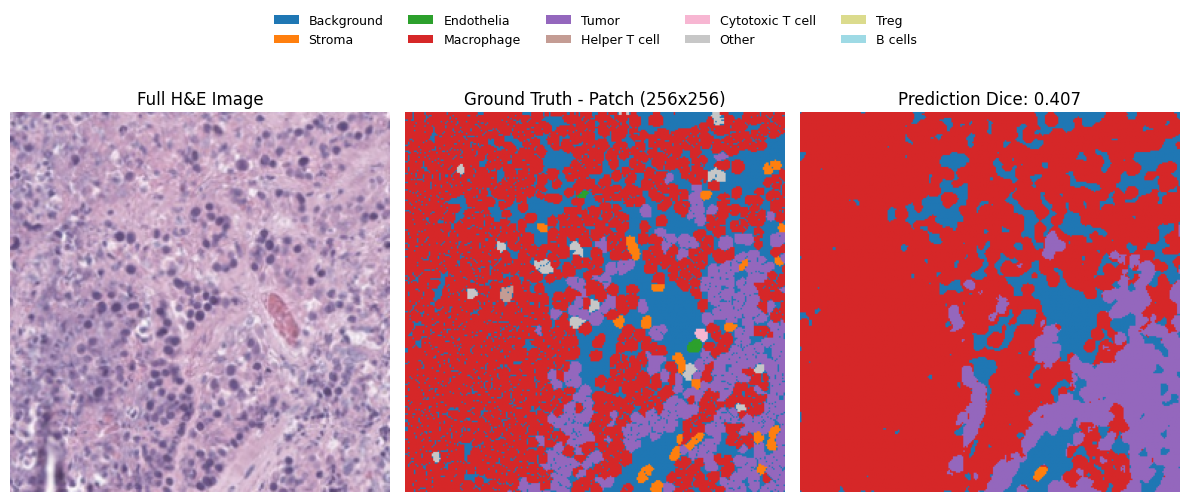

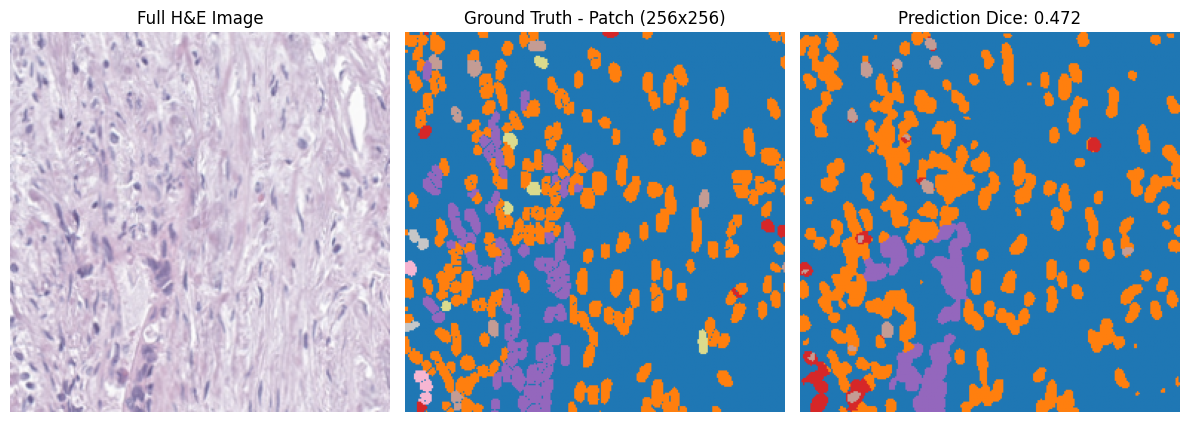

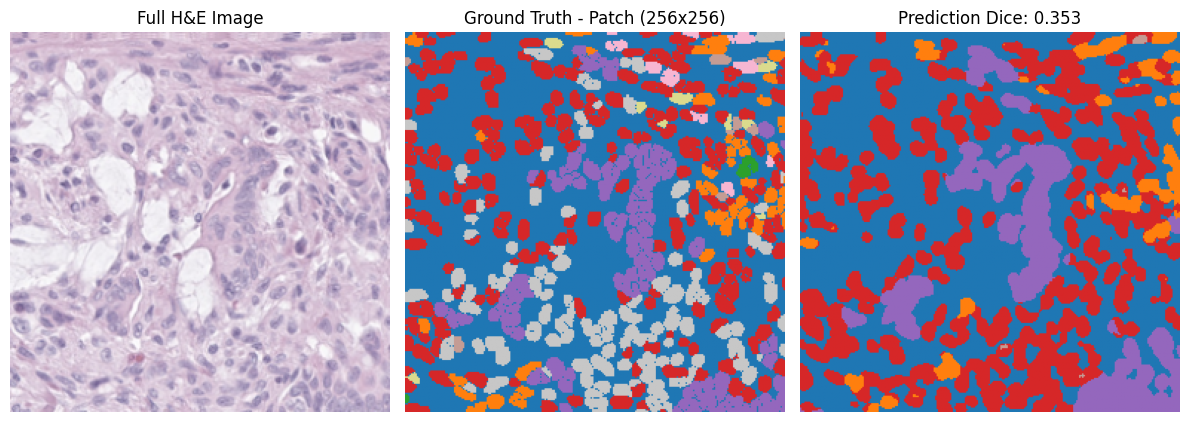

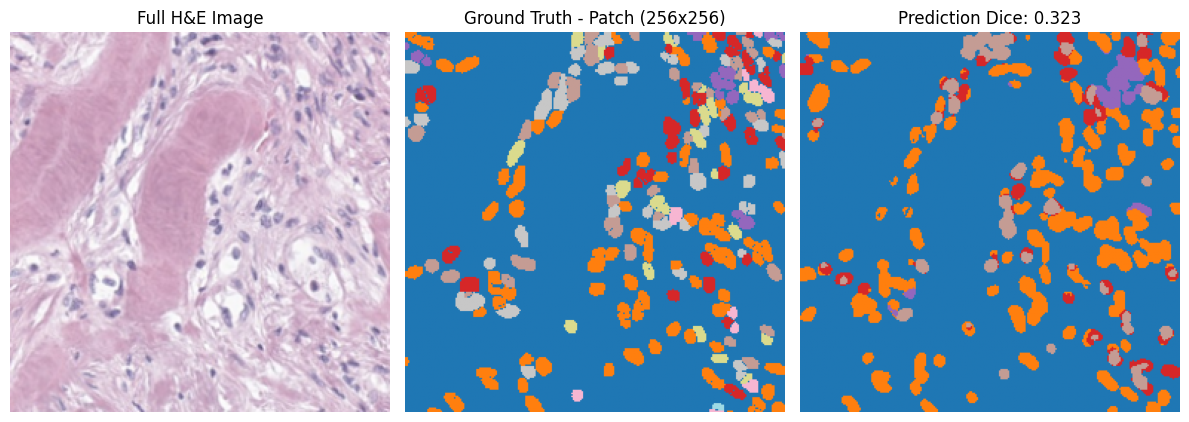

In [15]:
decoder.load_state_dict(torch.load(os.path.join(checkpoint_dir, "best_cellvit_he_only.pth")))
decoder.eval()

visualize_predictions(train_ds, num_images=4)

In [16]:
from src.utils.metrics import calculate_per_class_metrics

# print per class statistics
with torch.no_grad():
    pred_class_counts = torch.zeros(num_classes, dtype=torch.long)
    gt_class_counts = torch.zeros(num_classes, dtype=torch.long)

    all_preds = []
    all_masks = []

    for batch in test_loader:
        he_img, mask = batch
        he_img = he_img.to(device)
        mask = mask.to(device)

        _, _, z = model.encoder(he_img)  # (B, D, h, w)

        z1, z2, z3, z4 = z  # intermediate feature maps
        patch_dim = [int(d / 16) for d in [he_img.shape[-2], he_img.shape[-1]]]
        z4 = z4[:, 1:, :].transpose(-1, -2).view(-1, 384, *patch_dim) # without cls token
        z3 = z3[:, 1:, :].transpose(-1, -2).view(-1, 384, *patch_dim)
        z2 = z2[:, 1:, :].transpose(-1, -2).view(-1, 384, *patch_dim)
        z1 = z1[:, 1:, :].transpose(-1, -2).view(-1, 384, *patch_dim)

        input = [he_img, z1, z2, z3, z4]

        outputs = decoder(input)
        pred_logits = outputs["nuclei_type_map"]

        # class counts
        pred_mask = torch.argmax(pred_logits, dim=1)  # (B, H, W)
        for c in range(num_classes):
            pred_class_counts[c] += (pred_mask == c).sum().item()
            gt_class_counts[c] += (mask == c).sum().item()

        all_preds.append(pred_mask.cpu())
        all_masks.append(mask.cpu())

    all_preds = torch.cat(all_preds, dim=0)
    all_masks = torch.cat(all_masks, dim=0)

    stats = calculate_per_class_metrics(all_preds, all_masks, num_classes)

    pred_class_counts = pred_class_counts * 100 / pred_class_counts.sum()
    gt_class_counts = gt_class_counts * 100 / gt_class_counts.sum()
    for c in range(num_classes):
        print(
            f"Class {c}: Pred = {pred_class_counts[c].item():.2f}%, Ground Truth = {gt_class_counts[c].item():.2f}%, Dice = {stats[f'Class_{c}']['dice']:.4f}"
        )

Class 0: Pred = 67.67%, Ground Truth = 67.47%, Dice = 0.9092
Class 1: Pred = 10.90%, Ground Truth = 10.40%, Dice = 0.5102
Class 2: Pred = 0.00%, Ground Truth = 0.97%, Dice = 0.0000
Class 3: Pred = 10.13%, Ground Truth = 8.72%, Dice = 0.4966
Class 4: Pred = 8.07%, Ground Truth = 7.12%, Dice = 0.7325
Class 5: Pred = 3.23%, Ground Truth = 2.30%, Dice = 0.2211
Class 6: Pred = 0.00%, Ground Truth = 1.46%, Dice = 0.0000
Class 7: Pred = 0.00%, Ground Truth = 0.83%, Dice = 0.0000
Class 8: Pred = 0.00%, Ground Truth = 0.37%, Dice = 0.0000
Class 9: Pred = 0.00%, Ground Truth = 0.37%, Dice = 0.0000
